In [1]:
import os
import scipy.misc
import numpy as np
import cv2
import ra

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images, cols = 1):
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, cmap='gray')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
height = 320  # 320, 218
width = 256   # 256, 178

In [2]:
#flags

flags = tf.app.flags
flags.DEFINE_integer("epoch", 30, "Epoch to train [20]") # changed to 20 from  25
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 4, "The size of batch images [64]")
flags.DEFINE_integer("input_height", height, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", width, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", height, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", width, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "train_img_slices", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint_mri1000", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples_mri10000", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
#data = glob("./img_align_celeba/*.jpg")[3005:3009]
data = glob("./data/valid_img_slices/*.ra")
#np.random.shuffle(data)

sample_files = data[0:4]
#sample = [get_image_old1(sample_file, True) for sample_file in sample_files]
#sample = [cv2.resize(s, dsize=(256, 320)) for s in sample]
sample = [get_image_old2(sample_file) for sample_file in sample_files]

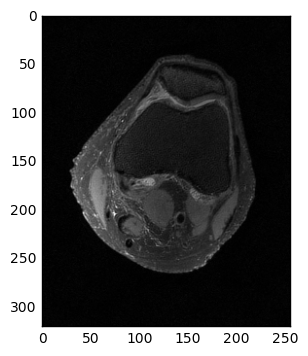

In [4]:
plt.imshow(sample[0], cmap ='gray')
plt.show()

In [5]:
#v = np.reshape(sample, (4, height*width))

v = np.reshape(sample, (4, height*width))[3:4]

# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (1, 81920)


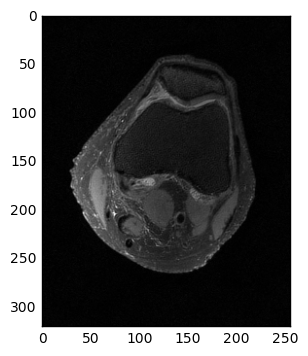

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

KeyboardInterrupt: 

In [6]:
possible_ms = [10000, 100, 500, 1000, 2000, 5000, 6000]
num_iter = 1300#2000
compressed_images = []

plt.imshow(sample[0], cmap='gray')
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    #for m in possible_ms:
    for i in range(1):
        
        '''A = np.random.randn(n, m).astype('float32')
        A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
        y = np.dot(v, A) 

        y_placeholder = tf.placeholder(tf.float32,[None,m])
        print('number of measurements = {}'.format(m))
        

        # -----------------------------------
        # our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [4, -1]) , A) - y_placeholder)**2, 1)) '''
        
        y_placeholder2 = tf.placeholder(tf.float32,[None,n])
        #our_loss = tf.reduce_mean(tf.reduce_sum((tf.reshape(dcgan.G, [4, -1]) - y_placeholder2)**2, 1)) 
        
        print('dcgan shape')
        print(np.shape(tf.reshape(dcgan.G, [4, -1])[0:1]))
        print('y shape')
        print(np.shape(y_placeholder2))
        
        our_loss = tf.reduce_sum(((tf.reshape(dcgan.G, [4, -1])[3:4] - y_placeholder2)**2)) 
        #lp = 50
        #lp_loss = tf.reduce_mean(tf.norm(y_placeholder2, ord=6, axis=1))
        # -----------------------------------

        #z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss + lp * lp_loss, var_list=dcgan.z)  
        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)
        
        count = 0
        errors = []

        for i in range(num_iter): 
            # a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder2: v})
            count += 1
            errors.append(closs)
            if np.mod(count, 100) == 1:                
                print('iteration {}'.format(count))
                print(closs)
        plt.imshow(b[0].reshape((height, width)), cmap='gray')
        compressed_images.append(b)
        plt.show()

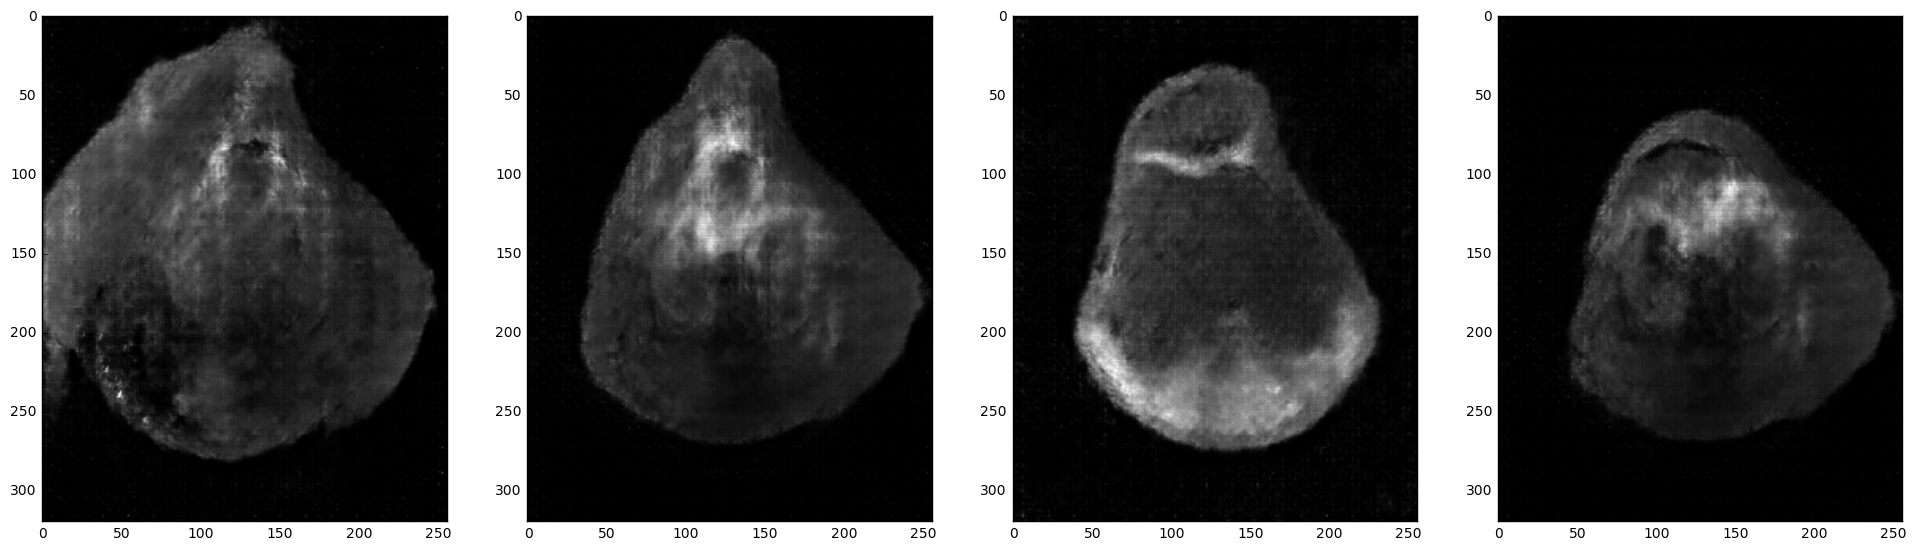

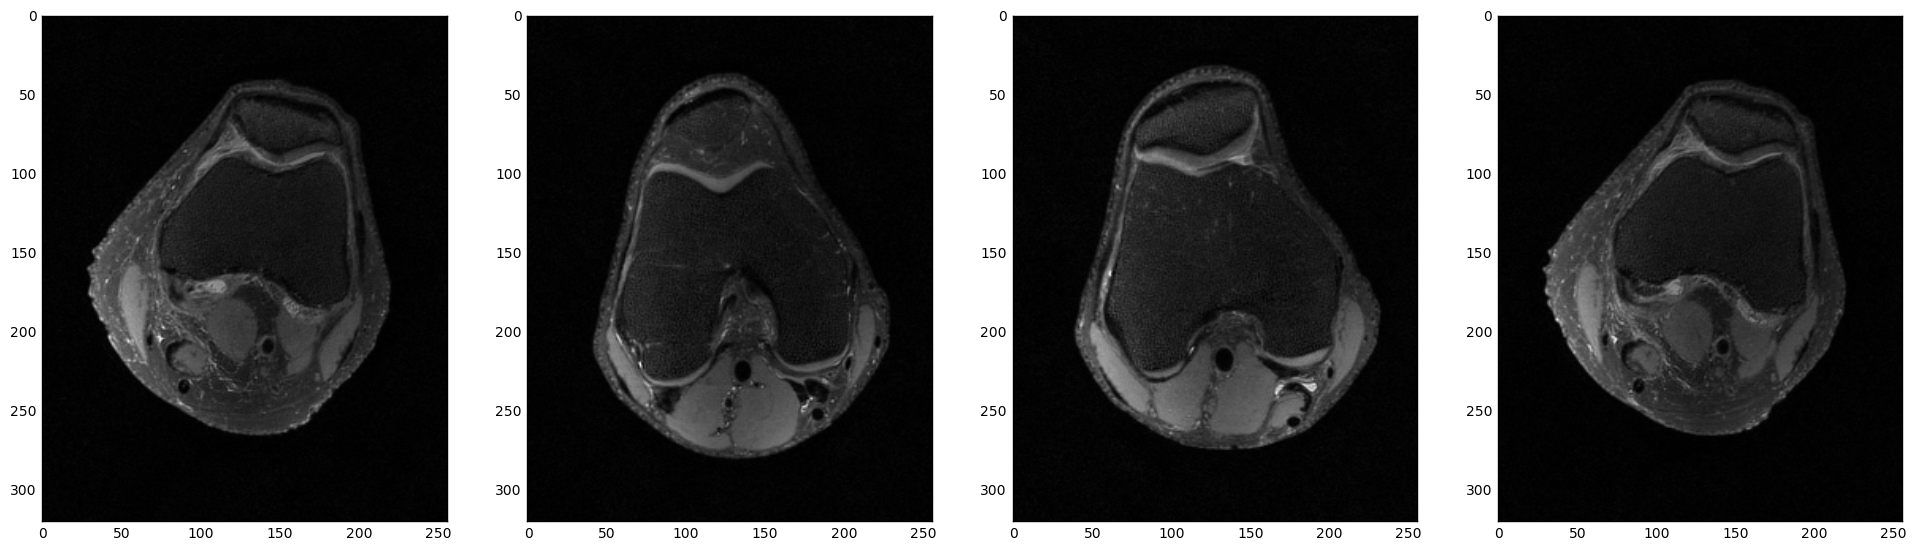

In [7]:
show_images(np.reshape(compressed_images, (4,  height, width)))
show_images(sample)

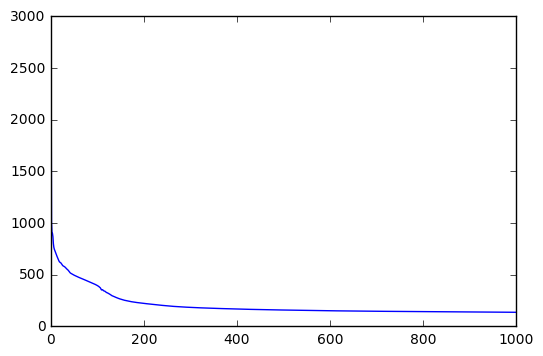

In [8]:
plt.plot(errors)
plt.show()

In [9]:
'''np.save('./Notes/data/recon_mri/1_reconstructed_test_3', np.reshape(compressed_images, (4,  height, width)))
np.save('./Notes/data/recon_mri/1_original_test_3', sample)'''

In [8]:
data = glob("./masks/masks/*.ra")

img = ra.read_ra(data[2]) 
mag = abs(img)
mag = (mag > 0.5)*1.
the_mask = np.fft.fftshift(mag)
m = sum(sum(the_mask))

print(np.shape(the_mask))
print(m)
print(the_mask.tolist())

(256, 320)
13476.0
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,